## -=Подготовка к запуску=-

### Установка пакетов

В случае, если пакеты через requirements.тхт установлены не были, блок ниже установит все необходимые пакеты для работы данного блокнота.

In [ ]:
%pip install ultralytics==8.0.198
%pip install Pillow==10.0.1
%pip install numpy==1.24.3
%pip install opencv-python==4.6.0.66

### Импорт библиотек

In [1]:
import cv2
import numpy as np
from PIL import Image
from ultralytics import YOLO

Импорт функций из detectors.py, в данном файле находятся все функции связанные с детекцией и моделями, они вынесены в отдельный файл для удобства работы.

In [2]:
import detectors

Импорт вспомогательных функций из utils.py, вынесены вотдельный файл так же для удобства.

In [3]:
import utils

## -=Загрузка моделей=-

Всего есть два ансамбля по 3 модели:
1. Для обработки RGB изображений
2. Для обработки tiff изображений

Оба ансамбля были проверены, и имеют примерно одинаковую точность и предсказания.
Обучение модели одновременно на детекцию в tiff и RGB снижает её общую точность.

In [34]:
#Ансамбль РГБ
model1 = YOLO("models/seg.pt")
model2 = YOLO("models/seg.pt")
model3 = YOLO("models/seg.pt")
models_RGB = [model1, model2, model3]

## -=Сегментация+Классификация=-

### Сегментация содержимого кузова и его классификация

Загрузка изображения

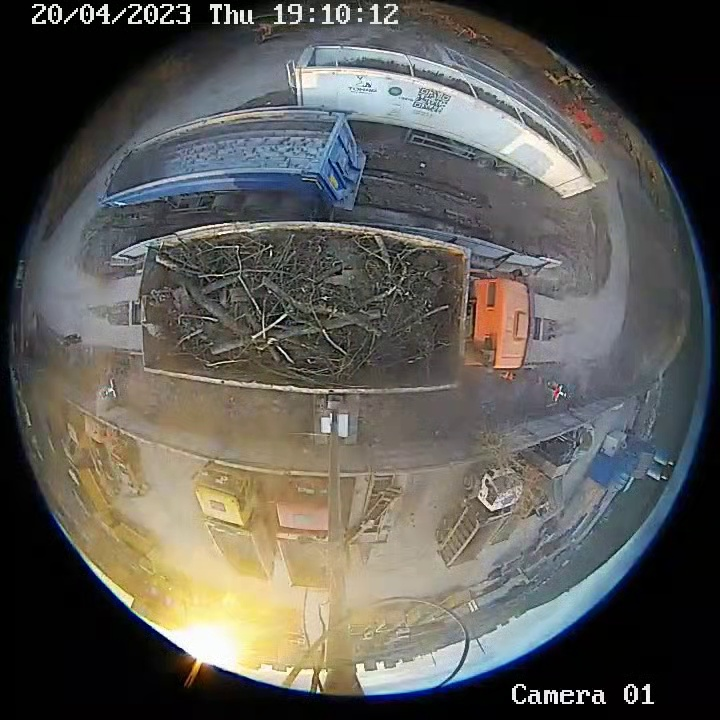

In [35]:
image = Image.open("examples/1.jpg")
display(image)

Сегментация

Сегментирую
examples/1.jpg


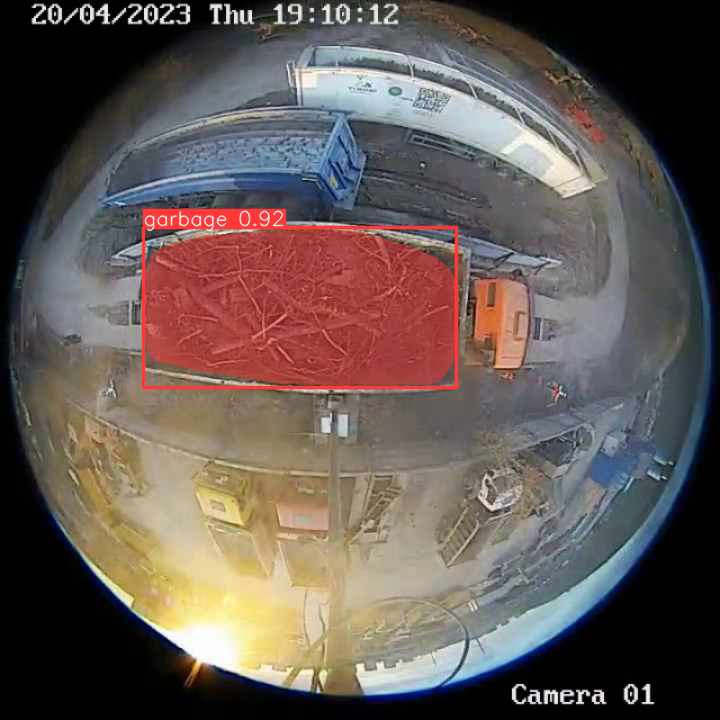

Сегментирую
examples/2.jpg


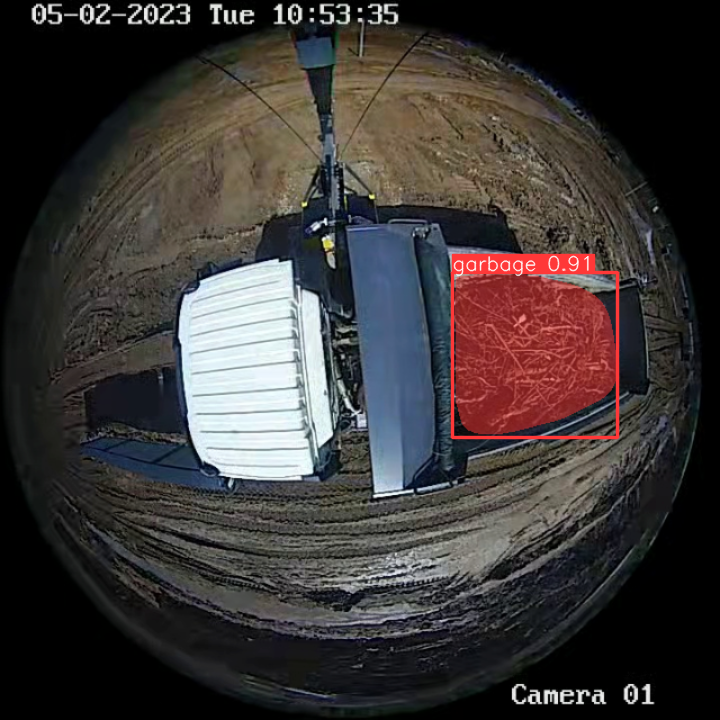

Сегментирую
examples/3.jpg


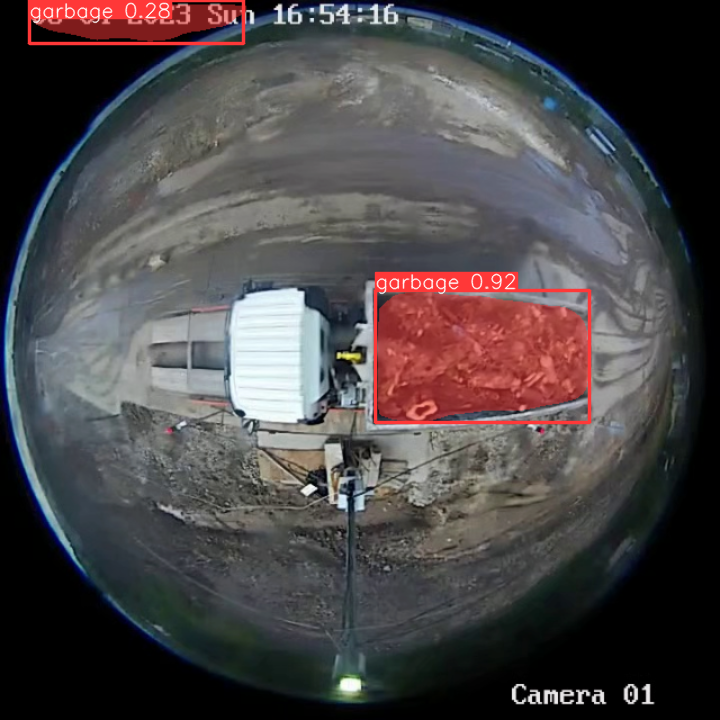

Сегментирую
examples/4.jpg


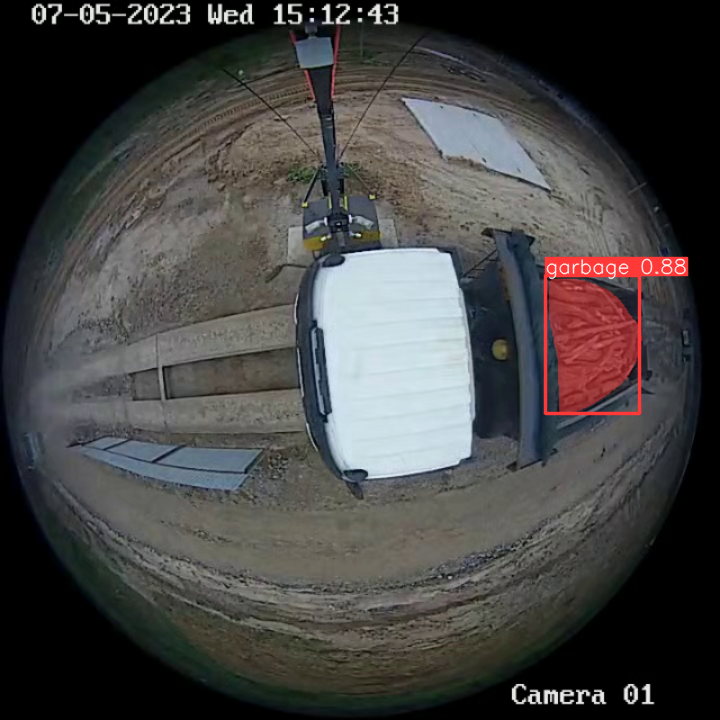

Сегментирую
examples/5.jpg


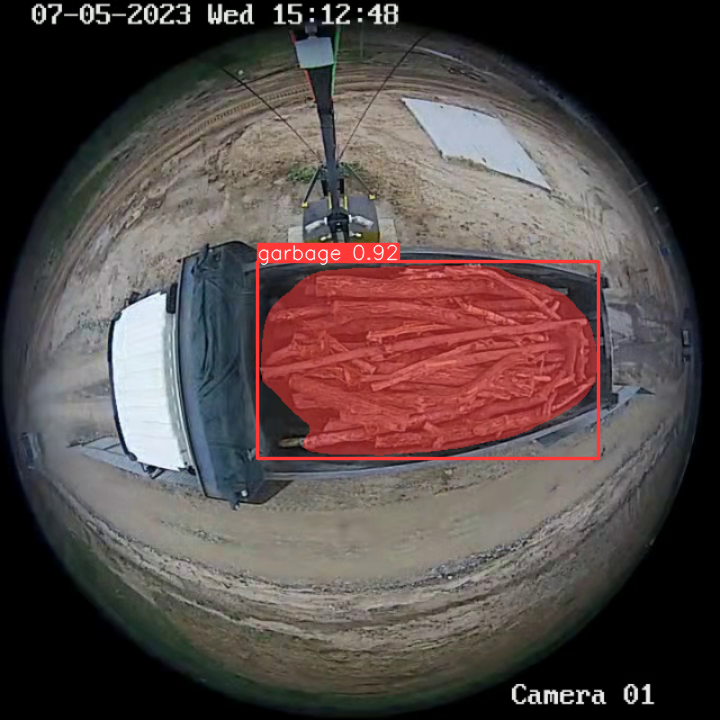

Сегментирую
examples/6.jpg


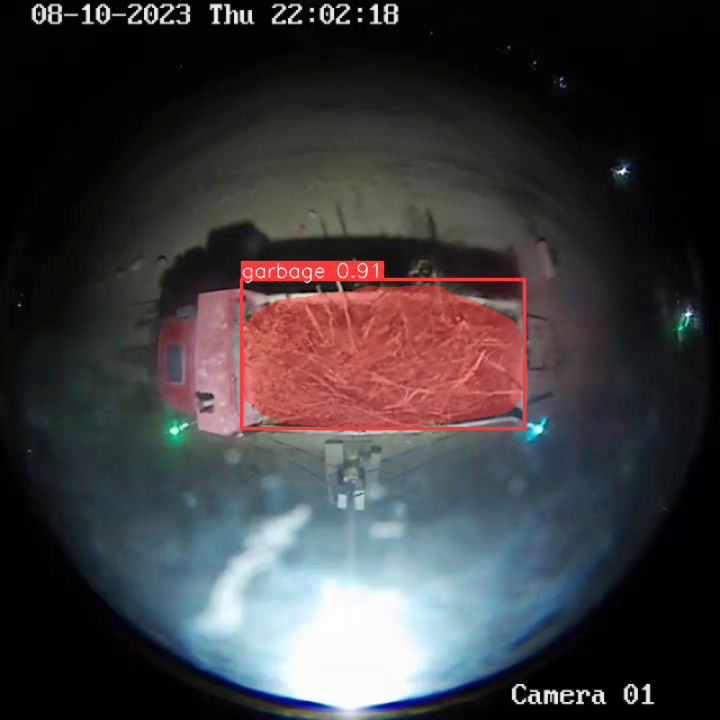

Сегментирую
examples/7.jpg


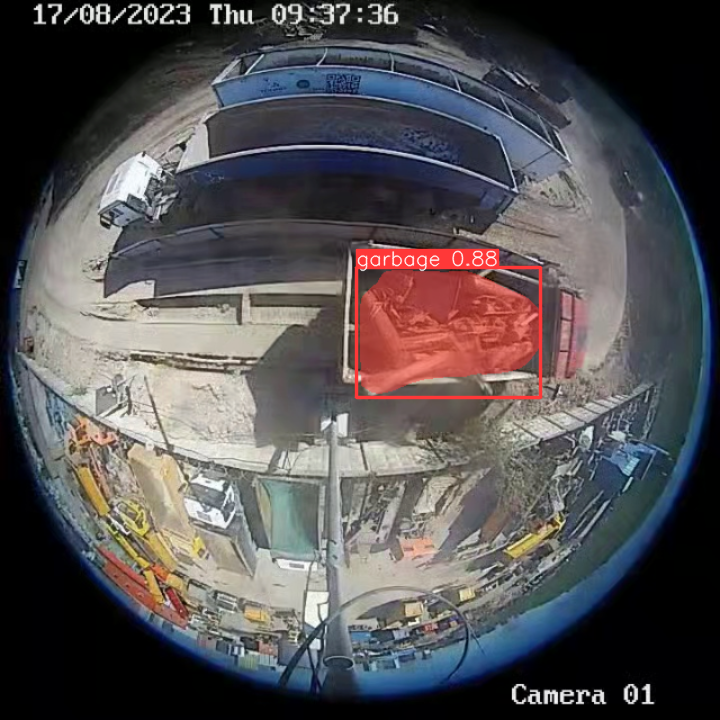

Сегментирую
examples/8.jpg


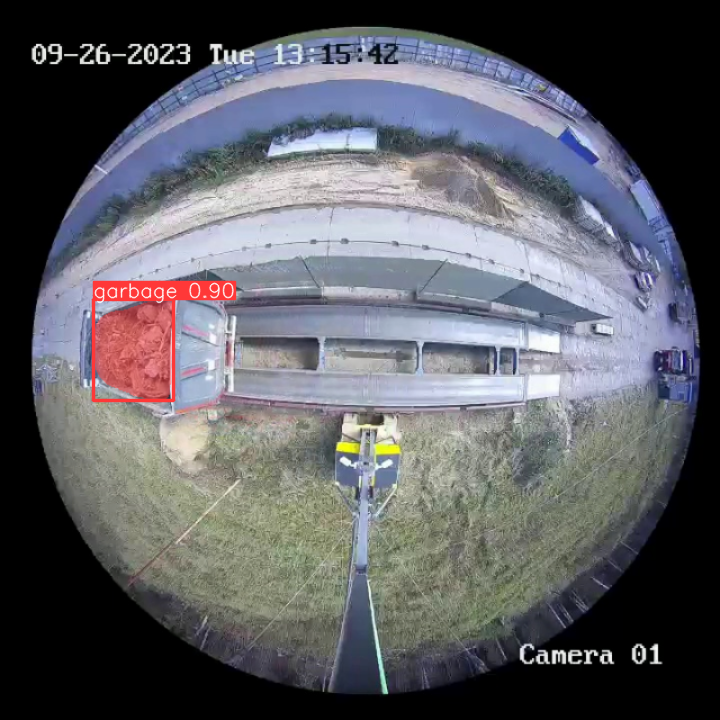

Сегментирую
examples/9.jpg


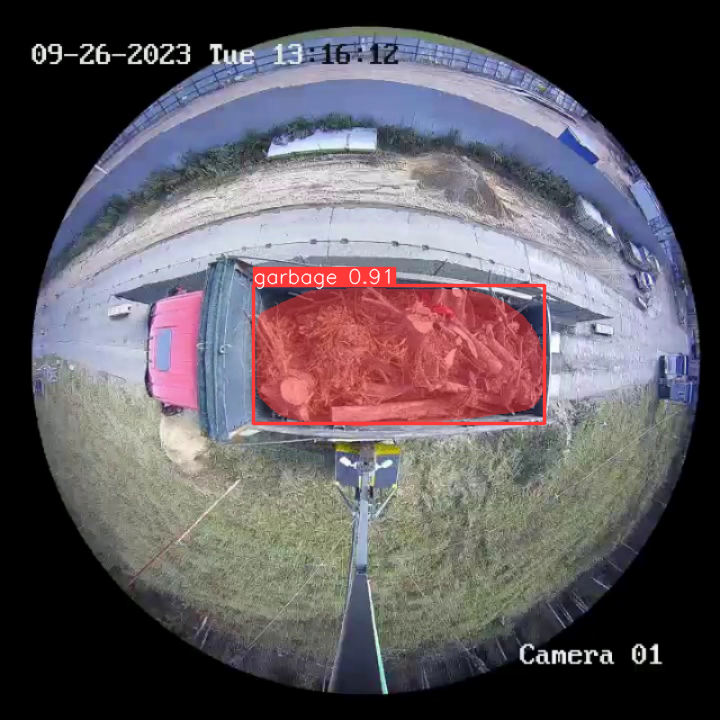

Сегментирую
examples/10.jpg


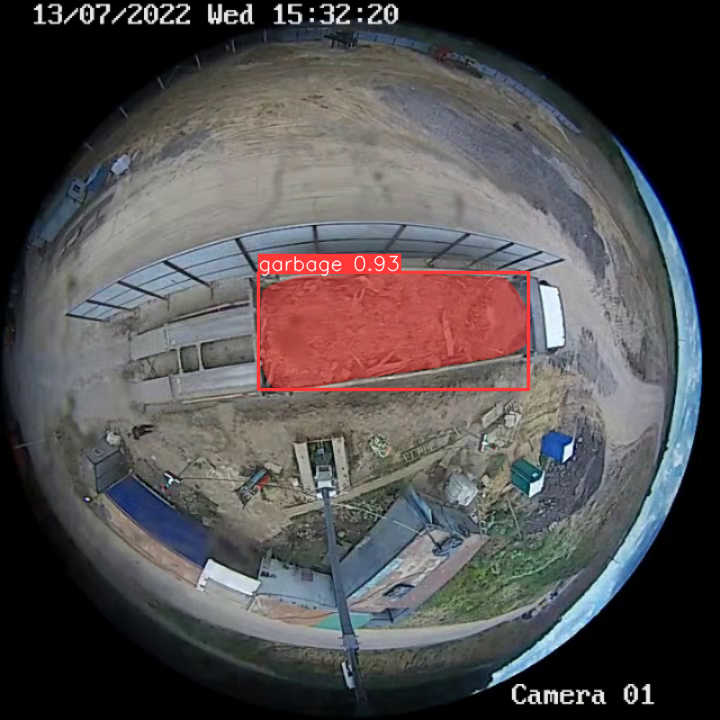

In [36]:
for i in [1,2,3,4,5,6,7,8,9,10]:
    image = Image.open(f"examples/{i}.jpg")
    image, results = detectors.run_model(models_RGB, image)
    print(f"examples/{i}.jpg")
    display(image)


Получаем часть изображения выделенную маской

In [9]:
image_for_cls = None
if(results[0].masks is not None):
    # Convert mask to single channel image
    mask_raw = results[0].masks[0].cpu().data.numpy().transpose(1, 2, 0)
    
    # Convert single channel grayscale to 3 channel image
    mask_3channel = cv2.merge((mask_raw,mask_raw,mask_raw))

    # Get the size of the original image (height, width, channels)
    h2, w2, c2 = results[0].orig_img.shape
    
    # Resize the mask to the same size as the image (can probably be removed if image is the same size as the model)
    mask = cv2.resize(mask_3channel, (w2, h2))

    # Convert BGR to HSV
    hsv = cv2.cvtColor(mask, cv2.COLOR_BGR2HSV)

    # Define range of brightness in HSV
    lower_black = np.array([0,0,0])
    upper_black = np.array([0,0,1])

    # Create a mask. Threshold the HSV image to get everything black
    mask = cv2.inRange(mask, lower_black, upper_black)

    # Invert the mask to get everything but black
    mask = cv2.bitwise_not(mask)

    # Apply the mask to the original image
    masked = cv2.bitwise_and(results[0].orig_img, results[0].orig_img, mask=mask)

    # Show the masked part of the image
    cv2.imwrite("output.png",masked)

Пропуск полученного изображения через классификатор

In [ ]:
image, results = detectors.run_model(models_RGB, image)
display(image)

### Детекция на изображениях tiff

In [ ]:
def run_full_cycle(models, data, ensemle = False, route = "accurate"):
    """
    Функция представляет собой полный цикл обработки данных, будь то видео или изображение

    Parameters:
    models: пачка моделей.
    data: данные.
    ensemble: используется ли ансамбль.
    route: выбор типа цикла 'fast' или 'accurate'.
    """
    def cycle(image):
       result_img, results = run_model(models, image, "class_truck")
       print(results[4])

    file_extension = utils.check_file_extension('example.txt')

    if file_extension == ".png" or file_extension == ".jpg":
        pass

    elif file_extension == ".mp4":
        pass

Выбор длины волны из 400, 430, 460, 490, 520, 550, 580, 610, 640, 670, 700

От 0 до 10 соответственно

In [7]:
wave_length = 4

Загрузка изображения

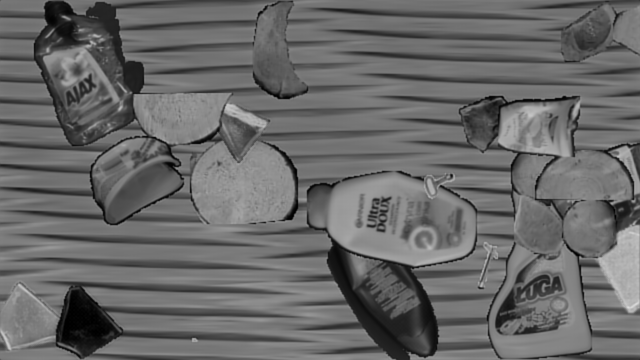

In [8]:
image = tifffile.imread('examples/0000.tif')
channel = image[wave_length, :, :]
channel = (channel * 255).astype(np.uint8)
channel_image = Image.fromarray(channel)       
display(channel_image)

Детекция


0: 384x640 7 woods, 7 glasss, 7 plastics, 3 metals, 80.4ms
Speed: 5.5ms preprocess, 80.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 woods, 7 glasss, 7 plastics, 3 metals, 40.6ms
Speed: 0.0ms preprocess, 40.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 woods, 7 glasss, 7 plastics, 3 metals, 34.5ms
Speed: 0.0ms preprocess, 34.5ms inference, 5.5ms postprocess per image at shape (1, 3, 384, 640)


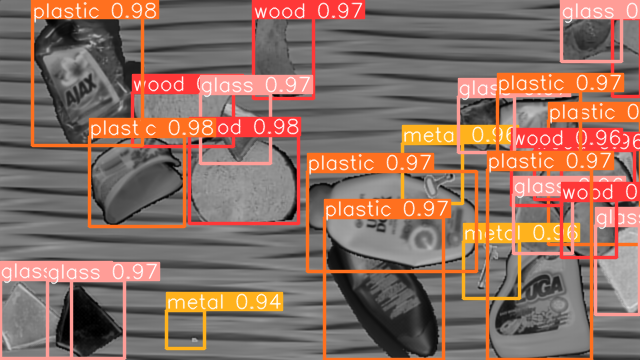

Дерево:7
Стекло:7
Пластик:7
Металл:3


In [9]:
image, results = detectors.ensemble_detect(models_tiff, channel_image)
display(image)
print(f"Дерево:{results[0]}")
print(f"Стекло:{results[1]}")
print(f"Пластик:{results[2]}")
print(f"Металл:{results[3]}")

### Детекция на видео и подсчёт общего количества уникальных объектов

Загрузка видео

In [ ]:
video_capture = cv2.VideoCapture('examples/output0.mp4')

Детекция

Детекция уникальных объектов происходит "в лоб": каждые 25 кадров берётся фрейм, результаты детекции подсчитываются и суммируются, да, звучит просто и наивно, но результаты сравнительно неплохие, особенно относительно треко-детекций которых мы находили с открытым исходным кодом.

К сожалению, показ самого видеопотока пока не предусмотрен

In [ ]:
res = []
counter = 0
while True:
    ret, frame = video_capture.read()
    if not ret:
        break  
             
    counter += 1    
    
    processed_frame, results = detectors.ensemble_detect(models_RGB, frame)
    if counter % 25 == 0:   
        res.append(results)
    sums = [sum(x) for x in zip(*res)]
        
print(f"Дерево:{sums[0]}")
print(f"Стекло:{sums[1]}")
print(f"Пластик:{sums[2]}")
print(f"Металл:{sums[3]}")

### Детекция на потоке с камеры устройства

Блок ниже запустит захват с устройства с номеном 0, после чего откроется новое окно, в котором будет показано изображение с потока с детекцией.
Задержка достаточно большая, эт освязано с тем, что в данном случае три модели отрабатывают последовательно, в теории, процесс можно ускорить, если использовать модели в многопоточном режиме.

Чтобы закрыть окно, необходимо нажать клавишу "ESC"

In [ ]:
vid = cv2.VideoCapture(0) 
  
while(True): 
    ret, frame = vid.read() 
    image, results = detectors.ensemble_detect(models_RGB, frame)
    new_image = np.array(image.convert('RGBA'), dtype=np.uint8)
    cv2.imshow('frame', new_image) 
      
    #"ESC" чтобы закрыть окно
    if cv2.waitKey(1) & 0xFF == 27:
        break
   
vid.release() 
cv2.destroyAllWindows() 

В данном блоке демонстрируется скорость работы с одной моделью

In [ ]:
vid = cv2.VideoCapture(0) 
  
while(True): 
    ret, frame = vid.read() 
    #frame = np.array(image.convert('RGB'), dtype=np.uint8)
    image, results = detectors.ensemble_detect([model1], frame)
    new_image = np.array(image.convert('RGBA'), dtype=np.uint8)
    cv2.imshow('frame', new_image) 
      
    #"ESC" чтобы закрыть окно
    if cv2.waitKey(1) & 0xFF == 27:
        break
   
vid.release() 
cv2.destroyAllWindows() 